#### **Extra Point**
  - Implement a 3D-CNN (e.g. 3D-ResNet or R(2+1)d-Net) for action classification on the KTH-Actions dataset
  - Compare it with the RNN-based models

#### **Our Choice**
  - **R(2+1)d-Net**
  - Reason: "... when used within a ResNet architecture, (2+1)D convolutions lead to state-of-theart results on 4 different benchmarks in action recognition" _ Tran et al.
  
  - This was, as per the authors, as compared to their other formulations such as Mixed Convolution (MC). Since they also claimed in the same paper that MC's performance mathces that of 3D-ResNets with 3 times as many parameters, we roughly take it that R(2+1)d-Net outperforms 3D-ResNet.

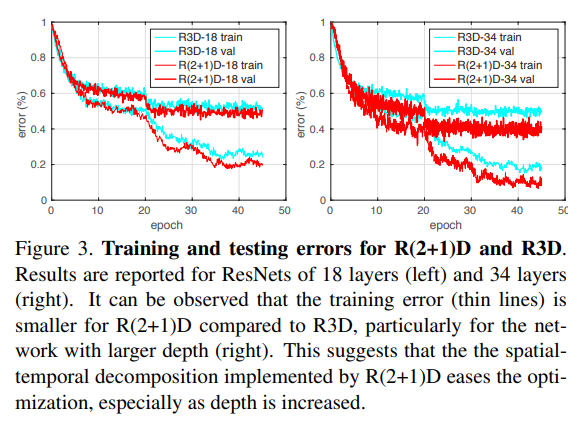

Courtesy of Tran et al. "A Closer Look at Spatiotemporal Convolutions for Action Recognition"

In [20]:
from utils import *
import shutil
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import random
import re
from transformations import get_train_transforms,get_test_transforms
from dataloader import KTHActionDataset
from torch.utils.tensorboard import SummaryWriter

#### Create the dataloaders

In [2]:
root_dir = "/home/nfs/inf6/data/datasets/kth_actions/processed/"

train_dataset = KTHActionDataset(root_dir, 
                                 split="train", 
                                 transform=get_train_transforms(), 
                                 max_frames=40, 
                                 img_size=(64, 64))

test_dataset = KTHActionDataset(root_dir, 
                                split="test", 
                                # transform=get_test_transforms(), 
                                transform=None,
                                max_frames=40, 
                                img_size=(64, 64))

In [24]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, 
                          batch_size=64, 
                          shuffle=True, 
                          num_workers=4)

test_loader = DataLoader(test_dataset, 
                         batch_size=64, 
                         shuffle=False, 
                         num_workers=4)

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [25]:
## Verifying the dataloader  
for batch in test_loader:
    frames, labels = batch
    print(f"Batch shape: {frames.shape}, Labels: {labels.shape}")
    break

NameError: name 'test_loader' is not defined

#### Model

In [9]:
import torch
from torchvision.models.video import r2plus1d_18;

In [10]:
model = r2plus1d_18(pretrained=True);

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# 6 output classes (for 6 actions)
model.fc = torch.nn.Linear(model.fc.in_features, 6)

In [12]:
model

VideoResNet(
  (stem): R2Plus1dStem(
    (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
    (1): BatchNorm3d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv2Plus1D(
          (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
          (1): BatchNorm3d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
        )
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [13]:
torch.cuda.is_available()

True

In [14]:
device = torch.device("cuda")

In [16]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Decay LR by a factor of 3 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [22]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "Task3_Logs", "R(2+1)d-Net_Tuned")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [26]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=15, tboard=writer
    )

NameError: name 'train_loader' is not defined

In [ ]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

smooth_loss = smooth(loss_iters, 31)
ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress")

epochs = np.arange(len(train_loss)) + 1
ax[1].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
ax[1].plot(epochs, val_loss, c="blue", label="Valid Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("CE Loss")
ax[1].set_title("Loss Curves")

epochs = np.arange(len(val_loss)) + 1
ax[2].plot(epochs, valid_acc, c="red", label="Valid accuracy", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Accuracy (%)")
ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc),2)}% @ epoch {np.argmax(valid_acc)+1})")

plt.show()